In [332]:
## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn import svm
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
    #fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict, pos_label=2)
import matplotlib.pyplot as plt
from sklearn import preprocessing
from mpl_toolkits.basemap import Basemap
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,classification_report
import datetime as dt
from mpl_toolkits.basemap import Basemap
from unbalanced_dataset import SMOTE


%matplotlib inline

HISTORY DATA/SEVERE WEATHER DATA(NOAA)
To get my data I used wget module in unix command to BULK download all the zip files from previous year

In [334]:
#In Python: Define a database name (event_db), and your username for your computer. 
dbname = 'event_db'
username = 'elahe'
#to run below commands PostgreSQL should be launched
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine('postgres://%s@localhost/%s'%('elahe','event_db'))
print(engine.url)
con = None
con = psycopg2.connect(database = 'event_db', user = 'elahe')

postgres://elahe@localhost/event_db


In [335]:
##### The threshold is set on one std away from 0.75 percentile
def preproccess_event(tornado,wet,cold,t1,t2,t3):
    eventPerMonthState_df =reduce(lambda df1,df2: pd.merge(df1,df2,on=['MONTH_NAME','STATE_FIPS','CZ_FIPS'],how='outer'), [tornado,wet,cold])
    eventPerMonthState_df['eventPerMonthState_ID'] = eventPerMonthState_df.index
    eventPerMonthState_df = eventPerMonthState_df.fillna(0)

    sql_query ="""
    select *
    from county_fips_lat_lon_table
    """
    county_fips_lat_lon = pd.read_sql_query(sql_query,con)

    eventPerMonthState_df['CZ_FIPS']=eventPerMonthState_df['CZ_FIPS'].astype(str)
    eventPerMonthState = pd.merge(eventPerMonthState_df,county_fips_lat_lon,on=['STATE_FIPS','CZ_FIPS'],how='left')
    eventPerMonthState['ID'] = eventPerMonthState.index
    eventPerMonthState=eventPerMonthState.dropna()

    features =  eventPerMonthState[["MONTH_NAME",'county_avg_lat','county_avg_lon']]
    month_mapping = {
        'January': 1,
        'February': 2,
        'March':3,
        'April':4,
        'May':5,
        'June':6,
        'July':7,
        'August':8,
        'September':9,
        'October':10,
        'November':11,
        'December':12
    }
    features['MONTH_NAME']=features['MONTH_NAME'].map(month_mapping)
    tornado_cnt = eventPerMonthState[['tornado_cnt']].values
    wet_cnt = eventPerMonthState[['wet_cnt']].values
    cold_cnt = eventPerMonthState[['cold_cnt']].values
    tornado_label = list(tornado_cnt)
    wet_label = list(wet_cnt)
    cold_label = list(cold_cnt)
    if t1==0 and t2==0 or t3==0:
        
        std1 = np.std(tornado['tornado_cnt'])
        t1_75 = np.percentile(tornado['tornado_cnt'], 75)
        t1_25 = np.percentile(tornado['tornado_cnt'], 25)
        t1_median = np.median(tornado['tornado_cnt'])
        t1_mean = np.mean(tornado['tornado_cnt'])
        t1 = std1+t1_75
        t1 = t1_median
        print t1


        std2 = np.std(wet['wet_cnt'])
        t2_75 = np.percentile(wet['wet_cnt'], 75)
        t2_25 = np.percentile(wet['wet_cnt'], 25)
        t2_median = np.median(wet['wet_cnt'])
        t2_mean = np.mean(wet['wet_cnt'])
       
        t2 = std2+t2_75
        t2=t2_median
        print t2

        std3 = np.std(cold['cold_cnt'])
        t3_75 = np.percentile(cold['cold_cnt'], 75)
        t3_25 = np.percentile(cold['cold_cnt'], 25)
        t3_median = np.median(cold['cold_cnt'])
        t3_mean = np.mean(cold['cold_cnt'])
        t3 = std3+t3_75
        t3=t3_25
        print t3
    
    tornado_label=label_dataset(tornado_label,t1)    
    wet_label=label_dataset(wet_label,t2) 
    cold_label=label_dataset(cold_label,t3)
    
    return t1,t2,t3,tornado_cnt,wet_cnt,cold_cnt,tornado_label,wet_label,cold_label,features 

In [336]:
def label_dataset(y_label,t):
    y_index = [i for i,v in enumerate(y_label) if v >= t]
    y_label = [0 for label in y_label]
    for idx in y_index:
        y_label[idx]=1 
    print 'Number of Events happend = %d'%len(y_index)
    print 'Nothing happened = %d'%(len(y_label)-len(y_index))
    return y_label

Visulaize your data (Time Series Analysis) then perfomr your training

In [337]:
sql_query = """
select count(*) as tornado_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS","YEAR" 
from  event_location_tornado_table
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS","YEAR"
having "YEAR"<2016;
"""
####This should be yearly normalized but for now I just divide it 
##by 18 number of years 2000 - 2017
tornado = pd.read_sql_query(sql_query,con)
print tornado.shape
#print tornado
sql_query = """
select count(*) as wet_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS","YEAR"
from event_location_wet_table 
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS","YEAR"
having "YEAR"<2016;
"""
wet = pd.read_sql_query(sql_query,con)
print wet.shape
sql_query = """
select count(*) as cold_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS","YEAR"
from event_location_cold_table
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS","YEAR"
having "YEAR"<2016;
"""
cold = pd.read_sql_query(sql_query,con)
print cold.shape


(15138, 5)
(41405, 5)
(97270, 5)


In [338]:
tornado.describe()

,tornado_cnt,STATE_FIPS,CZ_FIPS,YEAR
count,15138.000000,15138.000000,15138.000000,15138.000000
mean,1.461091,27.909433,103.350112,2007.395098
std,1.060986,15.036967,92.263124,4.455604
min,1.000000,1.000000,1.000000,2000.000000
25%,1.000000,17.000000,41.000000,2004.000000
50%,1.000000,28.000000,85.000000,2008.000000
75%,2.000000,40.000000,135.000000,2011.000000
max,22.000000,99.000000,810.000000,2015.000000


In [339]:
wet.describe()

,wet_cnt,STATE_FIPS,CZ_FIPS,YEAR
count,41405.000000,41405.000000,41405.000000,41405.000000
mean,1.477044,29.730661,81.617051,2007.446951
std,1.171934,17.400323,88.408994,4.507405
min,1.000000,1.000000,1.000000,2000.000000
25%,1.000000,18.000000,25.000000,2004.000000
50%,1.000000,27.000000,61.000000,2008.000000
75%,2.000000,41.000000,111.000000,2011.000000
max,36.000000,99.000000,840.000000,2015.000000


In [340]:
cold.describe()

,cold_cnt,STATE_FIPS,CZ_FIPS,YEAR
count,97270.000000,97270.000000,97270.000000,97270.000000
mean,1.682266,31.120202,51.440002,2007.917426
std,1.274682,14.723565,72.727179,4.646390
min,1.000000,1.000000,1.000000,2000.000000
25%,1.000000,20.000000,15.000000,2004.000000
50%,1.000000,31.000000,36.000000,2008.000000
75%,2.000000,42.000000,65.000000,2012.000000
max,40.000000,99.000000,569.000000,2015.000000


Number of Events happend = 3350
Nothing happened = 102475
Number of Events happend = 7002
Nothing happened = 98823
Number of Events happend = 9924
Nothing happened = 95901


/Users/elahe/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


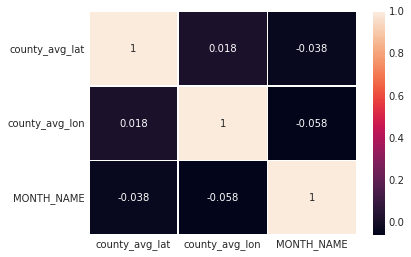

In [341]:
[t1,t2,t3,cnt_tornado,cnt_wet,cnt_cold,label_tornado,label_wet,label_cold,features]=preproccess_event(tornado,wet,cold,3,3,3)

sns.heatmap(features[['county_avg_lat','county_avg_lon','MONTH_NAME']].corr(), annot=True, linewidths=.5)
plt.show()

features['label_tornado']=label_tornado
features['label_cold']=label_cold
features['label_wet']=label_wet
features['cnt_tornado']=cnt_tornado
features['cnt_cold']=cnt_cold
features['cnt_wet']=cnt_wet

In [342]:
features.describe()

,MONTH_NAME,county_avg_lat,county_avg_lon,label_tornado,label_cold,label_wet,cnt_tornado,cnt_cold,cnt_wet
count,105825.000000,105825.000000,105825.000000,105825.000000,105825.000000,105825.000000,105825.000000,105825.000000,105825.000000
mean,5.514850,39.199506,-90.427085,0.031656,0.093777,0.066166,0.474897,1.010385,1.015752
std,3.730167,4.732802,12.814002,0.175083,0.291520,0.248573,0.913858,1.246334,1.182342
min,1.000000,19.679550,-164.860031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,36.450277,-97.250111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,39.537391,-89.275526,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,8.000000,42.583098,-81.384633,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,12.000000,48.871632,-67.477826,1.000000,1.000000,1.000000,22.000000,37.000000,36.000000


In [343]:
print features.head()

   MONTH_NAME  county_avg_lat  county_avg_lon  label_tornado  label_cold  \
0           7       28.858656      -82.452273              0           0   
1           7       28.858656      -82.452273              0           0   
2           7       28.858656      -82.452273              0           0   
3           7       28.858656      -82.452273              0           0   
4           7       28.858656      -82.452273              0           0   

   label_wet  cnt_tornado  cnt_cold  cnt_wet  
0          0          1.0       0.0      1.0  
1          0          1.0       0.0      1.0  
2          0          1.0       0.0      1.0  
3          0          1.0       0.0      1.0  
4          0          1.0       0.0      1.0  


In [344]:
features.groupby('MONTH_NAME').cnt_cold.sum()

MONTH_NAME
1     26637.0
2     24448.0
3     17003.0
4      6008.0
5      2034.0
6       495.0
7       266.0
8        46.0
9       260.0
10     1902.0
11     5259.0
12    22566.0
Name: cnt_cold, dtype: float64

In [345]:
month_count=features.groupby(['MONTH_NAME','county_avg_lat','county_avg_lon']).agg({'cnt_cold': 'sum'})
cold_month_cnt=month_count.sort_values('cnt_cold',ascending=False).reset_index()
cold_month_cnt.describe()

,MONTH_NAME,county_avg_lat,county_avg_lon,cnt_cold
count,25849.000000,25849.000000,25849.000000,25849.000000
mean,6.309180,38.267180,-90.922864,4.136485
std,3.386353,4.773192,11.439512,11.753587
min,1.000000,19.679550,-164.860031,0.000000
25%,3.000000,34.815649,-97.176686,0.000000
50%,6.000000,38.380377,-89.698262,0.000000
75%,9.000000,41.661319,-82.964907,3.000000
max,12.000000,48.871632,-67.477826,312.000000


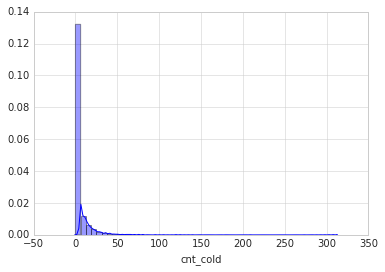

In [346]:
sns.distplot(cold_month_cnt['cnt_cold'])

In [347]:
features.groupby('MONTH_NAME').cnt_tornado.sum()

MONTH_NAME
1      1888.0
2      2820.0
3      3805.0
4      7008.0
5     10959.0
6      9406.0
7      4161.0
8      3051.0
9      2287.0
10     1351.0
11     1645.0
12     1875.0
Name: cnt_tornado, dtype: float64

In [348]:
month_count=features.groupby(['MONTH_NAME','county_avg_lat','county_avg_lon']).agg({'cnt_tornado': 'sum'})
tornado_month_cnt=month_count.sort_values('cnt_tornado',ascending=False).reset_index()
tornado_month_cnt.describe()

,MONTH_NAME,county_avg_lat,county_avg_lon,cnt_tornado
count,25849.000000,25849.000000,25849.000000,25849.000000
mean,6.309180,38.267180,-90.922864,1.944214
std,3.386353,4.773192,11.439512,6.256187
min,1.000000,19.679550,-164.860031,0.000000
25%,3.000000,34.815649,-97.176686,0.000000
50%,6.000000,38.380377,-89.698262,0.000000
75%,9.000000,41.661319,-82.964907,2.000000
max,12.000000,48.871632,-67.477826,220.000000


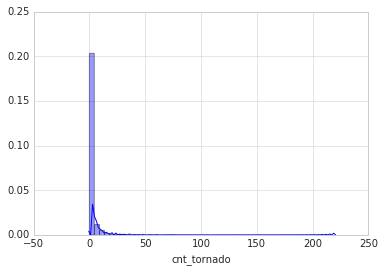

In [349]:
sns.distplot(tornado_month_cnt['cnt_tornado'])

In [350]:
features.groupby('MONTH_NAME').cnt_wet.sum()

MONTH_NAME
1      9564.0
2      9619.0
3     15588.0
4      9295.0
5     11131.0
6     12942.0
7      9066.0
8      7495.0
9      5053.0
10     3256.0
11     2818.0
12    11665.0
Name: cnt_wet, dtype: float64

In [351]:
month_count=features.groupby(['MONTH_NAME','county_avg_lat','county_avg_lon']).agg({'cnt_wet': 'sum'})
wet_month_cnt=month_count.sort_values('cnt_wet',ascending=False).reset_index()
wet_month_cnt.describe()

,MONTH_NAME,county_avg_lat,county_avg_lon,cnt_wet
count,25849.000000,25849.000000,25849.000000,25849.000000
mean,6.309180,38.267180,-90.922864,4.158459
std,3.386353,4.773192,11.439512,10.041863
min,1.000000,19.679550,-164.860031,0.000000
25%,3.000000,34.815649,-97.176686,0.000000
50%,6.000000,38.380377,-89.698262,1.000000
75%,9.000000,41.661319,-82.964907,4.000000
max,12.000000,48.871632,-67.477826,368.000000


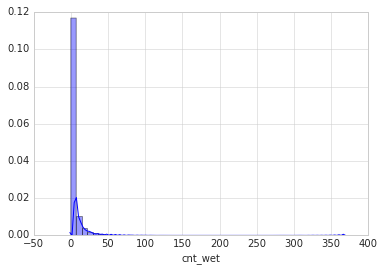

In [352]:
sns.distplot(wet_month_cnt['cnt_wet'])

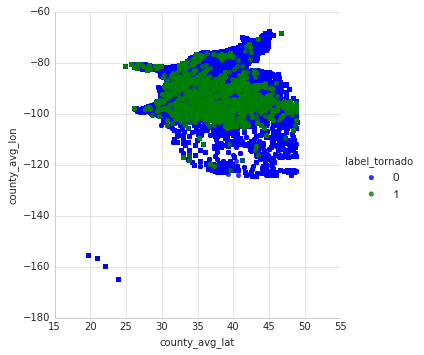

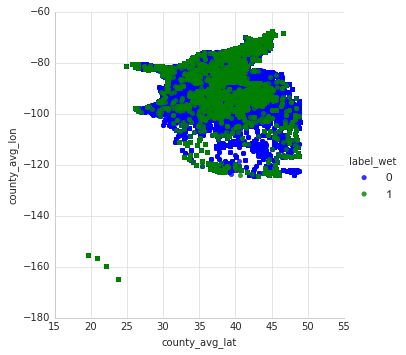

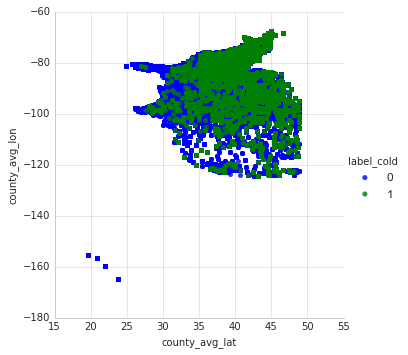

(3350, 9)
(7002, 9)
(9924, 9)
tornado mean=-93.980953 wet mean=-92.837388 cold mean=-88.933687


'df = features[[\'MONTH_NAME\',\'cnt_tornado\', \'cnt_wet\',\'cnt_cold\']]\ndf.sort_values([\'MONTH_NAME\']).plot(kind=\'bar\', title=\'Months\')\nplt.show()\nimport seaborn as sns\nsns.set_style("whitegrid")\n\nsns.stripplot(x="MONTH_NAME",y="cnt_tornado",hue="",data=features,jitter=True)\ndf = features[[\'cnt_tornado\', \'cnt_wet\',\'cnt_cold\']]\n#df[\'wet_cnt\'].plot(kind=\'bar\', title=\'Heavey Rain\', color=\'r\')\ndf[\'cnt_cold\'].plot(kind=\'bar\', title=\'Chill/Snow conditions\', color=\'g\')'

In [353]:



sns.set_style("whitegrid")
g = sns.lmplot('county_avg_lat','county_avg_lon',
              data=features,
              hue='label_tornado', fit_reg=False)
plt.show()

sns.set_style("whitegrid")
g = sns.lmplot('county_avg_lat','county_avg_lon',
              data=features,
              hue='label_wet', fit_reg=False)
plt.show()


sns.set_style("whitegrid")
g = sns.lmplot('county_avg_lat','county_avg_lon',
              data=features,
              hue='label_cold', fit_reg=False)
plt.show()



tornado_happened = features[features['label_tornado'] == 1]
tornado_happened_lon = tornado_happened['county_avg_lon']
tornado_happened_lat = tornado_happened['county_avg_lat']


wet_happened = features[features['label_wet'] == 1]
wet_happened_lon = wet_happened['county_avg_lon']
wet_happened_lat = wet_happened['county_avg_lat']


cold_happened = features[features['label_cold'] == 1]
cold_happened_lon = cold_happened['county_avg_lon']
cold_happened_lat = cold_happened['county_avg_lat']

print tornado_happened.shape
print wet_happened.shape
print cold_happened.shape
print "tornado mean=%f wet mean=%f cold mean=%f" %(np.mean(tornado_happened_lon),np.mean(wet_happened_lon),np.mean(cold_happened_lon))


"""df = features[['MONTH_NAME','cnt_tornado', 'cnt_wet','cnt_cold']]
df.sort_values(['MONTH_NAME']).plot(kind='bar', title='Months')
plt.show()
import seaborn as sns
sns.set_style("whitegrid")

sns.stripplot(x="MONTH_NAME",y="cnt_tornado",hue="",data=features,jitter=True)
df = features[['cnt_tornado', 'cnt_wet','cnt_cold']]
#df['wet_cnt'].plot(kind='bar', title='Heavey Rain', color='r')
df['cnt_cold'].plot(kind='bar', title='Chill/Snow conditions', color='g')"""

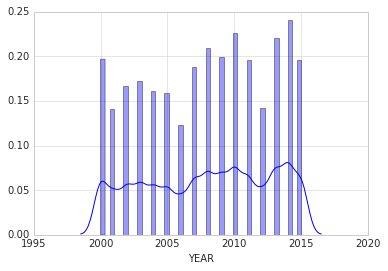

In [354]:
sns.distplot(cold['YEAR'])

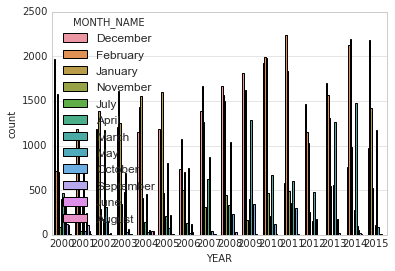

In [355]:
sns.countplot(cold['YEAR'],hue=cold['MONTH_NAME'])

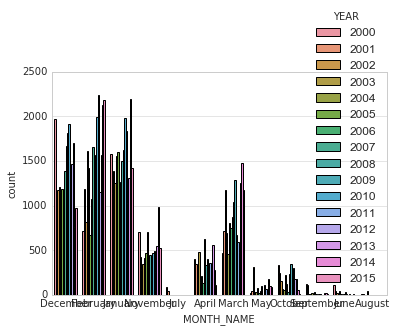

In [356]:
sns.countplot(cold['MONTH_NAME'],hue=cold['YEAR'])

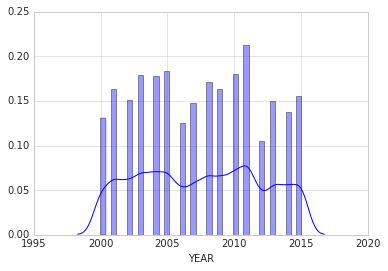

In [357]:
sns.distplot(wet['YEAR'])

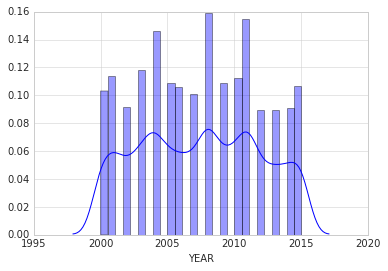

In [358]:
sns.distplot(tornado['YEAR'])

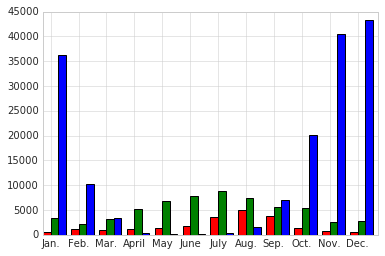

In [359]:
sql_query = """
select count(*) as tornado_cnt,"MONTH_NAME"
from 
(select "MONTH_NAME"
from event_location_tornado_table where "YEAR"< 2016) y 
group by "MONTH_NAME" order by "MONTH_NAME"
"""

tornado_perMOnth = pd.read_sql_query(sql_query,con)

sql_query = """
select count(*) as wet_cnt,"MONTH_NAME"
from
(select "MONTH_NAME"
from event_location_wet_table where "YEAR"< 2016) y 
group by "MONTH_NAME" order by "MONTH_NAME";
"""
wet_perMOnth = pd.read_sql_query(sql_query,con)

sql_query = """
select count(*) as cold_cnt,"MONTH_NAME"
from
(select "MONTH_NAME"
from event_location_cold_table where "YEAR"< 2016) y 
group by "MONTH_NAME" order by "MONTH_NAME";
"""
cold_perMOnth = pd.read_sql_query(sql_query,con)

month_mapping = {
        'January': 1,
        'February': 2,
        'March':3,
        'April':4,
        'May':5,
        'June':6,
        'July':7,
        'August':8,
        'September':9,
        'October':10,
        'November':11,
        'December':12
    }
cold_perMOnth['MONTH_NAME']=cold_perMOnth['MONTH_NAME'].map(month_mapping)
cold_perMOnth = cold_perMOnth.sort_values('MONTH_NAME',ascending=False)

wet_perMOnth['MONTH_NAME']=wet_perMOnth['MONTH_NAME'].map(month_mapping)
wet_perMOnth = wet_perMOnth.sort_values('MONTH_NAME',ascending=False)

tornado_perMOnth['MONTH_NAME']=tornado_perMOnth['MONTH_NAME'].map(month_mapping)
tornado_perMOnth = tornado_perMOnth.sort_values('MONTH_NAME',ascending=False)

x=[1,2,3,4,5,6,7,8,9,10,11,12]

yvals = tornado_perMOnth['tornado_cnt']
zvals=wet_perMOnth['wet_cnt']
kvals=cold_perMOnth['cold_cnt']

N = 12
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, yvals, width, color='r')

rects2 = ax.bar(ind+width, zvals, width, color='g')

rects3 = ax.bar(ind+width*2, kvals, width, color='b')

#ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Jan.', 'Feb.', 'Mar.','April', 'May', 'June','July', 'Aug.', 'Sep.','Oct.', 'Nov.', 'Dec.') )
#ax.legend( (rects1[0], rects2[0], rects3[0]), ('Tornado', 'Wet', 'Cold') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)

plt.show()



3350 3350
7002 7002
9924 9924


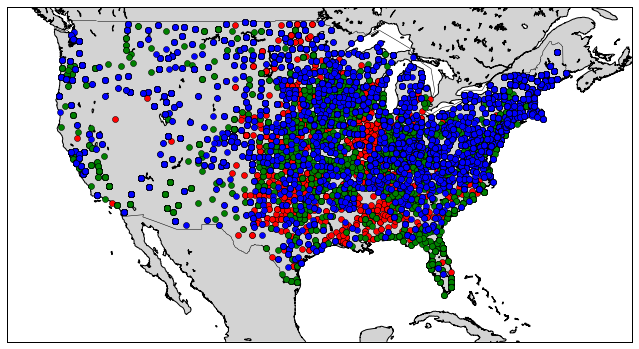

In [360]:
plt.figure(1)
# define Lambert Conformal basemap for North America.
plt.figure(figsize=(12,6))
map = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=50,\
            llcrnrlon=-130,urcrnrlon=-60,lat_ts=20,resolution='i')

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color='lightgray')
map.drawmapboundary()
print len(tornado_happened_lon),len(tornado_happened_lat)
x,y = map(np.array(tornado_happened_lon),np.array(tornado_happened_lat))
map.plot(x,y,'o',color='r')
print len(wet_happened_lon),len(wet_happened_lat)
x,y = map(np.array(wet_happened_lon),np.array(wet_happened_lat))
map.plot(x,y,'o',color='g')
print len(cold_happened_lon),len(cold_happened_lat)
x,y = map(np.array(cold_happened_lon),np.array(cold_happened_lat))
map.plot(x,y,'o',color='b')
plt.show()




In [390]:

sql_query = """
select count(*) as tornado_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS"
from 
(select "MONTH_NAME","STATE_FIPS","CZ_FIPS"
from event_location_tornado_table where "YEAR"< 2016) y 
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS"
"""

tornado = pd.read_sql_query(sql_query,con)
print tornado.shape
#print tornado
sql_query = """
select count(*) as wet_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS"
from
(select "MONTH_NAME","STATE_FIPS","CZ_FIPS"
from event_location_wet_table where "YEAR"< 2016) y 
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS";
"""
wet = pd.read_sql_query(sql_query,con)
print wet.shape
sql_query = """
select count(*) as cold_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS"
from
(select "MONTH_NAME","STATE_FIPS","CZ_FIPS"
from event_location_cold_table where "YEAR"< 2016) y 
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS";
"""
cold = pd.read_sql_query(sql_query,con)
print cold.shape


(9939, 4)
(21214, 4)
(19785, 4)


In [321]:
tornado.describe()

,tornado_cnt,STATE_FIPS,CZ_FIPS
count,9939.000000,9939.000000,9939.000000
mean,2.225375,28.333333,104.148103
std,2.253129,15.057362,93.874454
min,1.000000,1.000000,1.000000
25%,1.000000,18.000000,39.000000
50%,1.000000,28.000000,85.000000
75%,3.000000,40.000000,137.000000
max,40.000000,99.000000,810.000000


In [322]:
wet.describe()

,wet_cnt,STATE_FIPS,CZ_FIPS
count,21214.000000,21214.000000,21214.000000
mean,2.882860,31.004620,86.437023
std,3.541924,17.354316,93.888254
min,1.000000,1.000000,1.000000
25%,1.000000,18.000000,28.000000
50%,2.000000,29.000000,65.000000
75%,3.000000,42.000000,113.000000
max,106.000000,99.000000,840.000000


In [323]:
cold.describe()

,cold_cnt,STATE_FIPS,CZ_FIPS
count,19785.000000,19785.000000,19785.000000
mean,8.270609,30.726459,62.734698
std,9.272668,15.346256,91.503363
min,1.000000,1.000000,1.000000
25%,2.000000,19.000000,18.000000
50%,5.000000,30.000000,41.000000
75%,11.000000,44.000000,71.000000
max,103.000000,99.000000,569.000000


In [391]:
[t1_train,t2_train,t3_train,y1,y2,y3,y1_label,y2_label,y3_label,features]=preproccess_event(tornado,wet,cold,0,0,0)

######We can use following cmd if we want to TREAT MONTH AS CATEGORICAL VARIABLES WITH NO ORDER
#X = pd.get_dummies(X).values

##### THREAT MONTHS LIKE ORDINAL VARIABLE
#print features


X = features.values

#scaler = StandardScaler()
#scaler.fit(X)
#X =scaler.transform(X)
#bestC=pow(10,5)
#bestG=pow(10,-3)


1.0
2.0
2.0
Number of Events happend = 9833
Nothing happened = 16016
Number of Events happend = 10126
Nothing happened = 15723
Number of Events happend = 7354
Nothing happened = 18495


/Users/elahe/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [401]:
#clf_tornado = svm.SVC(C=bestC, gamma=bestG, kernel='rbf',class_weight={0:1,1:10})
#clf_tornado.fit(X, y1_label)
# Tried Smote to solve some of unbalanced data problem, didn't improve result that much

events_happend =sum(y1_label)
no_events = len(y1_label)-events_happend
#ratio =  no_events/ events_happend
smote = SMOTE(random_state=0,verbose=1, kind='regular')
uppX, uppy = smote.fit_transform(np.array(X), np.array(y1_label))

clf_tornado_rfc = RandomForestClassifier(n_estimators = 100,random_state=0)
clf_tornado_rfc.fit(uppX, uppy)
events_happend =sum(uppy)
no_events = len(uppy)-events_happend
print events_happend,no_events

Determining classes statistics... 2 classes detected: {0: 16016, 1: 9833}
Finding the 5 nearest neighbours...done!
Creating synthetic samples...Generated 9833 new samples ...
done!
19666.0 16016.0


In [326]:
#clf_wet = svm.SVC(C=bestC, gamma=bestG, kernel='rbf',class_weight={0:1,1:3})
#clf_wet.fit(X, y2_label) 

clf_wet_rfc = RandomForestClassifier(n_estimators = 100,random_state=0)
clf_wet_rfc.fit(X, y2_label)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [327]:
#clf_cold = svm.SVC(C=bestC, gamma=bestG, kernel='rbf',class_weight={0:1,1:3})
#clf_cold.fit(X, y3_label) 

clf_cold_rfc = RandomForestClassifier(n_estimators = 100,random_state=0)
clf_cold_rfc.fit(X, y3_label)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [392]:
features.head()

,MONTH_NAME,county_avg_lat,county_avg_lon
0,6,39.385852,-88.792758
1,5,43.347822,-90.372310
2,4,33.215153,-92.572388
3,10,42.741246,-96.628691
4,9,28.410015,-97.750528


In [399]:
features['tornado_label']=y1_label
features['wet_label']=y2_label
features['cold_label']=y3_label

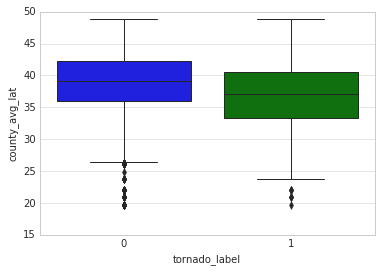

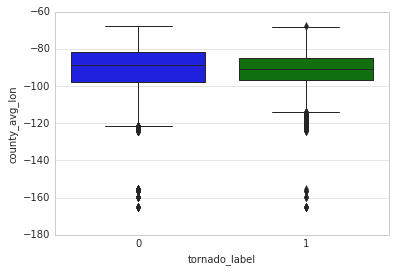

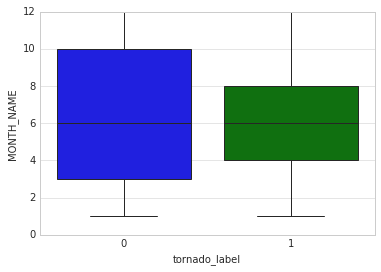

In [397]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="tornado_label", y='county_avg_lat', data=features)
plt.show()
ax = sns.boxplot(x="tornado_label", y='county_avg_lon', data=features)
plt.show()
ax = sns.boxplot(x="tornado_label", y='MONTH_NAME', data=features)
plt.show()

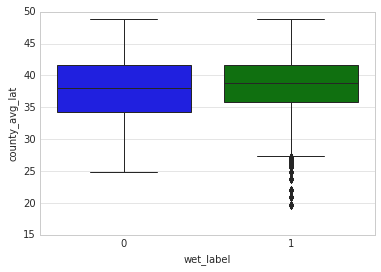

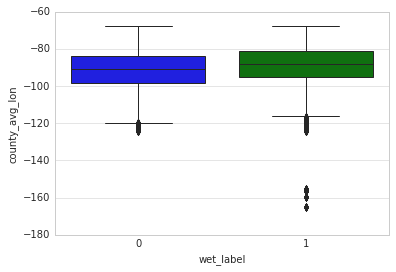

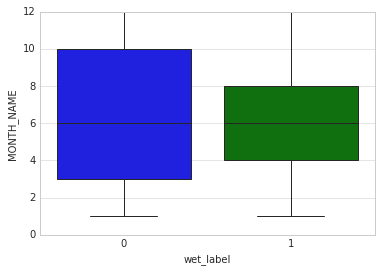

In [400]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="wet_label", y='county_avg_lat', data=features)
plt.show()
ax = sns.boxplot(x="wet_label", y='county_avg_lon', data=features)
plt.show()
ax = sns.boxplot(x="wet_label", y='MONTH_NAME', data=features)
plt.show()

In [328]:
def show_accuracy(y_test, y_predict):

        fpr, tpr, thresh = roc_curve(y_test, y_predict)
        roc_auc = auc(fpr, tpr)
        plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic',fontsize=20)
        plt.legend(loc="lower right")
        fig1 = plt.gcf()
        plt.show()
        [per, rec, f1, NoImp] = metrics.precision_recall_fscore_support(y_test, y_predict, average='macro')
        acc = metrics.accuracy_score(y_test, y_predict)
        print "Accuracy = %f percision = %f recall= %f F1_score= %f" % (acc, per, rec, f1)



Test your model on the data from year 2016

In [329]:

tornado_year = pd.read_sql_query(sql_query,con)
sql_query = """
select count(*) as tornado_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS"
from
(select "MONTH_NAME","STATE_FIPS","CZ_FIPS"
from event_location_tornado_table where "YEAR"= 2016) y 
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS";
"""

tornado = pd.read_sql_query(sql_query,con)
#print tornado
sql_query = """
select count(*) as wet_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS"
from
(select "MONTH_NAME","STATE_FIPS","CZ_FIPS"
from event_location_wet_table where "YEAR"= 2016) y 
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS";
"""
wet = pd.read_sql_query(sql_query,con)
sql_query = """
select count(*) as cold_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS"
from
(select "MONTH_NAME","STATE_FIPS","CZ_FIPS"
from event_location_cold_table where "YEAR"= 2016) y 
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS";
"""
cold = pd.read_sql_query(sql_query,con)

[t1,t2,t3,y1_test,y2_test,y3_test,y1_label_test,y2_label_test,y3_label_test,X_test]=preproccess_event(tornado,wet,cold,t1_train,t2_train,t3_train)


Number of Events happend = 775
Nothing happened = 4117
Number of Events happend = 695
Nothing happened = 4197
Number of Events happend = 751
Nothing happened = 4141


/Users/elahe/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Tornado Data---------------
             precision    recall  f1-score   support

 No_Tornado       0.92      0.77      0.84      4117
    Tornado       0.35      0.64      0.45       775

avg / total       0.83      0.75      0.78      4892



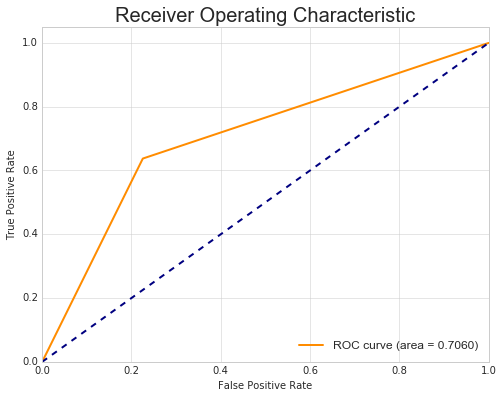

Accuracy = 0.752862 percision = 0.633209 recall= 0.706006 F1_score= 0.645176


In [330]:
y1_predict_rfc=clf_tornado_rfc.predict(X_test)

print "Tornado Data---------------"
print classification_report(y1_label_test,y1_predict_rfc,target_names = ['No_Tornado','Tornado'])
show_accuracy(y1_label_test,y1_predict_rfc)

In [ ]:
y1_predict=clf_tornado.predict(X_test)

print "Tornado Data---------------"
print classification_report(y1_label_test,y1_predict,target_names = ['No_Tornado','Tornado'])
show_accuracy(y1_label_test,y1_predict)

In [ ]:
y2_predict=clf_wet.predict(X_test)

print "Wet Data---------------"
print classification_report(y2_label_test,y2_predict,target_names = ['No_HeavyRain','HeavyRain'])
show_accuracy(y2_label_test,y2_predict)

Wet Data---------------
              precision    recall  f1-score   support

No_HeavyRain       0.94      0.65      0.77      4197
   HeavyRain       0.26      0.73      0.38       695

 avg / total       0.84      0.66      0.71      4892



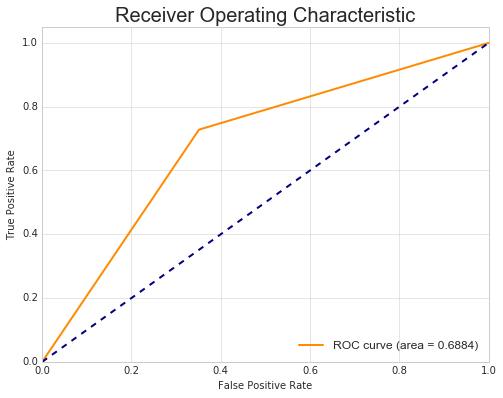

Accuracy = 0.660057 percision = 0.595326 recall= 0.688427 F1_score= 0.572194


In [289]:
y2_predict_rfc=clf_wet_rfc.predict(X_test)
print "Wet Data---------------"
print classification_report(y2_label_test,y2_predict_rfc,target_names = ['No_HeavyRain','HeavyRain'])
show_accuracy(y2_label_test,y2_predict_rfc)

In [ ]:
y3_predict=clf_cold.predict(X_test)

print "Cold Data---------------"
print classification_report(y3_label_test,y3_predict,target_names = ['No_Blizzard','Blizzard'])
show_accuracy(y3_label_test,y3_predict)

Cold Data---------------
             precision    recall  f1-score   support

No_Blizzard       0.99      0.57      0.72      4141
   Blizzard       0.29      0.98      0.45       751

avg / total       0.89      0.63      0.68      4892



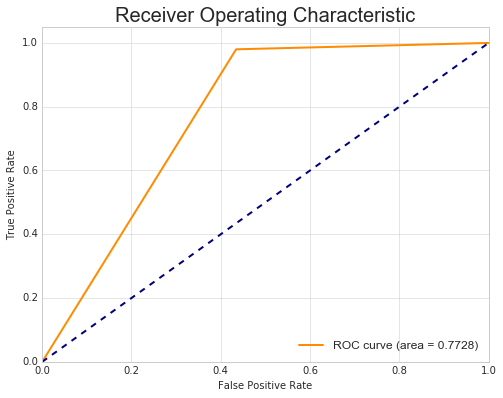

Accuracy = 0.629191 percision = 0.641986 recall= 0.772795 F1_score= 0.584399


In [331]:
y3_predict_rfc=clf_cold_rfc.predict(X_test)
print "Cold Data---------------"
print classification_report(y3_label_test,y3_predict_rfc,target_names = ['No_Blizzard','Blizzard'])
show_accuracy(y3_label_test,y3_predict_rfc)

In [365]:

sql_query = """
select count(*) as tornado_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS" 
from 
(select "MONTH_NAME","STATE_FIPS","CZ_FIPS"
from event_location_tornado_table) y 
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS"
"""
####This should be yearly normalized but for now I just divide it 
##by 18 number of years 2000 - 2017
tornado = pd.read_sql_query(sql_query,con)
print tornado.shape
#print tornado
sql_query = """
select count(*) as wet_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS"
from
(select "MONTH_NAME","STATE_FIPS","CZ_FIPS"
from event_location_wet_table) y 
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS";
"""
wet = pd.read_sql_query(sql_query,con)
print wet.shape
sql_query = """
select count(*) as cold_cnt,"MONTH_NAME","STATE_FIPS","CZ_FIPS"
from
(select "MONTH_NAME","STATE_FIPS","CZ_FIPS"
from event_location_cold_table) y 
group by "MONTH_NAME","STATE_FIPS","CZ_FIPS";
"""
cold = pd.read_sql_query(sql_query,con)
print cold.shape

[t1,t2,t3,y1,y2,y3,y1_label,y2_label,y3_label,X]=preproccess_event(tornado,wet,cold,0,0,0)

######We can use following cmd if we want to TREAT MONTH AS CATEGORICAL VARIABLES WITH NO ORDER
#X = pd.get_dummies(X).values

##### THREAT MONTHS LIKE ORDINAL VARIABLE
clf_tornado_rfc = RandomForestClassifier(n_estimators = 100,random_state=0)
clf_tornado_rfc.fit(X, y1_label)
joblib.dump(clf_tornado_rfc, 'tornado_rfcmodel.pkl')

clf_wet_rfc = RandomForestClassifier(n_estimators = 100,random_state=0)
clf_wet_rfc.fit(X, y2_label)
joblib.dump(clf_wet_rfc, 'wet_rfcmodel.pkl')

clf_cold_rfc = RandomForestClassifier(n_estimators = 100,random_state=0)
clf_cold_rfc.fit(X, y3_label)
joblib.dump(clf_cold_rfc, 'cold_rfcmodel.pkl')

(10601, 4)
(21943, 4)
(20036, 4)
1.0
2.0
2.0
Number of Events happend = 10484
Nothing happened = 15956
Number of Events happend = 10791
Nothing happened = 15649
Number of Events happend = 7439
Nothing happened = 19001


/Users/elahe/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['cold_rfcmodel.pkl']